In [63]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"Versi TensorFlow: {tf.__version__}")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ SUKSES: GPU Terdeteksi ({gpus[0].name}) - Memory Growth Aktif")
    except RuntimeError as e:
        print(f"❌ Error Config GPU: {e}")
else:
    print("⚠️ PERINGATAN: GPU tidak terdeteksi. Training berjalan di CPU.")

Versi TensorFlow: 2.10.1
✅ SUKSES: GPU Terdeteksi (/physical_device:GPU:0) - Memory Growth Aktif


In [64]:
DATASET_DIR = 'Dataset_Anggur'
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.2

if not os.path.exists(DATASET_DIR):
    print(f"❌ ERROR KRUSIAL: Folder '{DATASET_DIR}' tidak ditemukan!")

In [65]:
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=SPLIT_RATIO
)

print("\nMemuat Dataset...")
try:
    # Generator Latihan
    train_generator = data_gen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    test_generator = data_gen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    NUM_CLASSES = train_generator.num_classes
    class_names = list(train_generator.class_indices.keys())
    print(f"Kelas Terdeteksi ({NUM_CLASSES}): {class_names}")

    # Hitung Penyeimbang Data (Class Weights)
    cls_train = train_generator.classes
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(cls_train),
        y=cls_train
    )
    weights_dict = dict(enumerate(class_weights))
    print(f"Bobot Penyeimbang Aktif: {weights_dict}")

except Exception as e:
    print(f"❌ Error Data: {e}")
    NUM_CLASSES = 0 # Safety flag


Memuat Dataset...
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Kelas Terdeteksi (4): ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Penyeimbang Aktif: {0: 0.8609639830508474, 1: 0.7341915085817525, 2: 0.9439605110336817, 3: 2.3974926253687316}


In [66]:
def build_custom_cnn():
    model = Sequential(name='Custom_CNN')
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    for filters in [32, 64, 128, 256]:
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

def build_mobilenet():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True  # Full Fine-tuning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name='MobileNetV2')
    return model

In [67]:
def plot_battle_results(history_storage):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    for name, hist in history_storage.items():
        plt.plot(hist['val_accuracy'], linewidth=3, label=f'{name} (Test)')
        plt.plot(hist['accuracy'], linestyle='--', linewidth=1, alpha=0.7, label=f'{name} (Train)')
    plt.title('Battle: Perbandingan Akurasi')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for name, hist in history_storage.items():
        plt.plot(hist['val_loss'], linewidth=3, label=f'{name} (Test)')
    plt.title('Battle: Perbandingan Loss (Makin Rendah Makin Baik)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    
    plt.tight_layout(); plt.show()

def show_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print(f"\nLaporan Klasifikasi {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
models_list = [
    ('Custom CNN', build_custom_cnn),
    ('MobileNetV2', build_mobilenet)
]

battle_results = {}
cached_models = {}

if NUM_CLASSES > 0:
    for name, builder in models_list:
        print(f"\n{'='*40}")
        print(f"🚀 MULAI TRAINING: {name}")
        print(f"{'='*40}")

        tf.keras.backend.clear_session()
        
        model = builder()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        try:
            history = model.fit(
                train_generator,
                steps_per_epoch=train_generator.samples // BATCH_SIZE,
                validation_data=test_generator,
                validation_steps=test_generator.samples // BATCH_SIZE,
                epochs=EPOCHS,
                class_weight=weights_dict,
                verbose=1
            )
            
            cached_models[name] = model 
            
            print(f"\nMenghitung Statistik Akhir {name}...")
            test_generator.reset()
            probs = model.predict(test_generator, verbose=0)
            y_pred = np.argmax(probs, axis=1)
            y_true = test_generator.classes
            
            battle_results[name] = {
                'history': history.history,
                'y_true': y_true,
                'y_pred': y_pred
            }
            
        except Exception as e:
            print(f"❌ Error saat training {name}: {e}")


🚀 MULAI TRAINING: Custom CNN
Epoch 1/10
203/203 [==============================] - 54s 259ms/step - loss: 0.7734 - accuracy: 0.7842 - val_loss: 4.5314 - val_accuracy: 0.0913
Epoch 2/10
203/203 [==============================] - 52s 254ms/step - loss: 0.5799 - accuracy: 0.8550 - val_loss: 2.5134 - val_accuracy: 0.3338
Epoch 3/10
203/203 [==============================] - 52s 253ms/step - loss: 0.4988 - accuracy: 0.8810 - val_loss: 1.5090 - val_accuracy: 0.6062
Epoch 4/10
203/203 [==============================] - 84s 411ms/step - loss: 0.4787 - accuracy: 0.8980 - val_loss: 0.6912 - val_accuracy: 0.7713
Epoch 5/10
203/203 [==============================] - 99s 486ms/step - loss: 0.4149 - accuracy: 0.9224 - val_loss: 0.4378 - val_accuracy: 0.9225
Epoch 6/10
 52/203 [======>.......................] - ETA: 1:07 - loss: 0.4498 - accuracy: 0.9075


📊 HASIL AKHIR


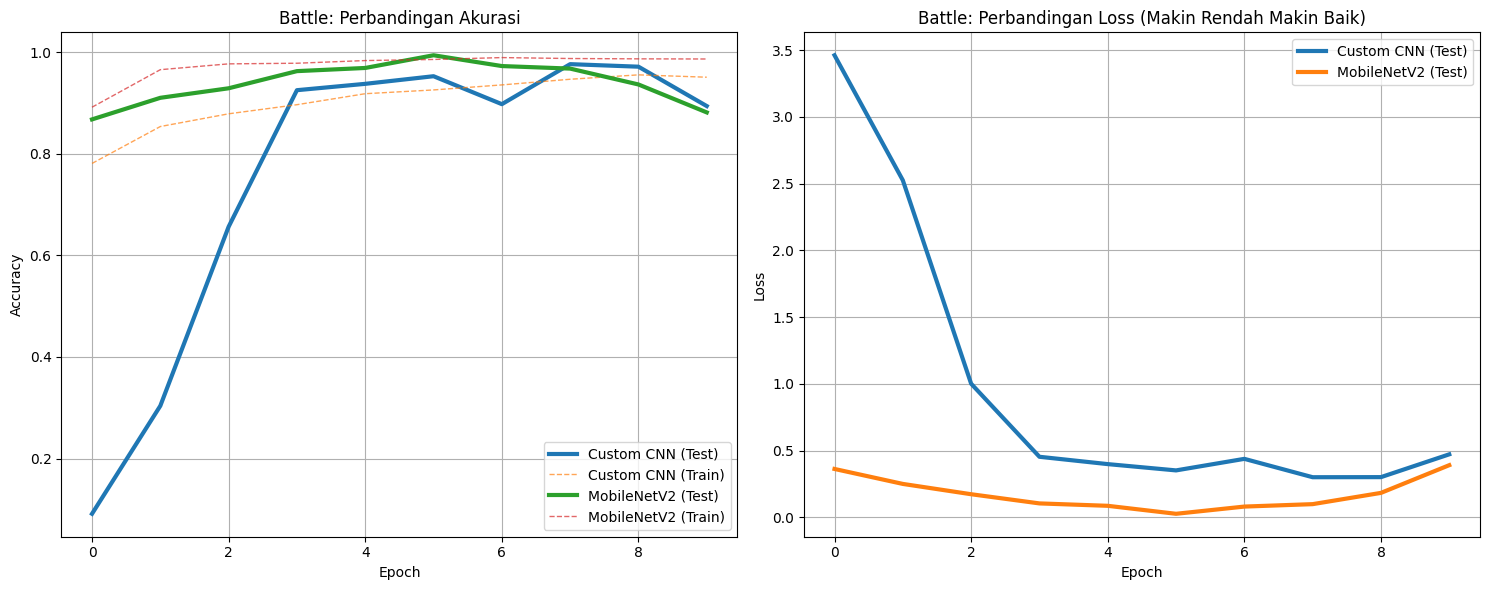


>>> Analisis Detail: Custom CNN <<<


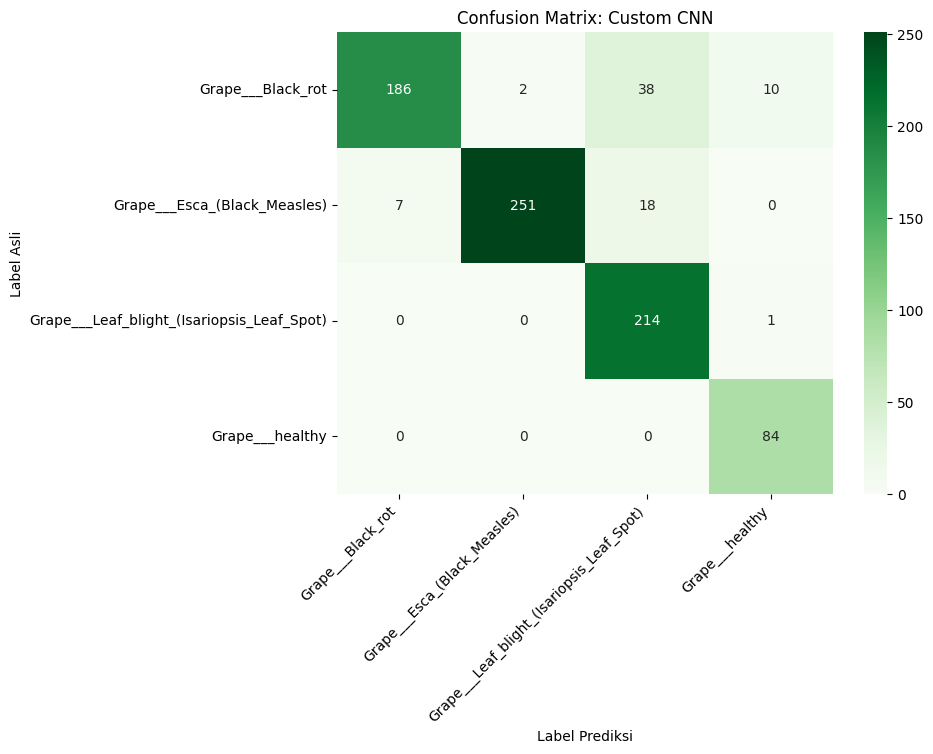


Laporan Klasifikasi Custom CNN:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.96      0.79      0.87       236
              Grape___Esca_(Black_Measles)       0.99      0.91      0.95       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.79      1.00      0.88       215
                           Grape___healthy       0.88      1.00      0.94        84

                                  accuracy                           0.91       811
                                 macro avg       0.91      0.92      0.91       811
                              weighted avg       0.92      0.91      0.91       811


>>> Analisis Detail: MobileNetV2 <<<


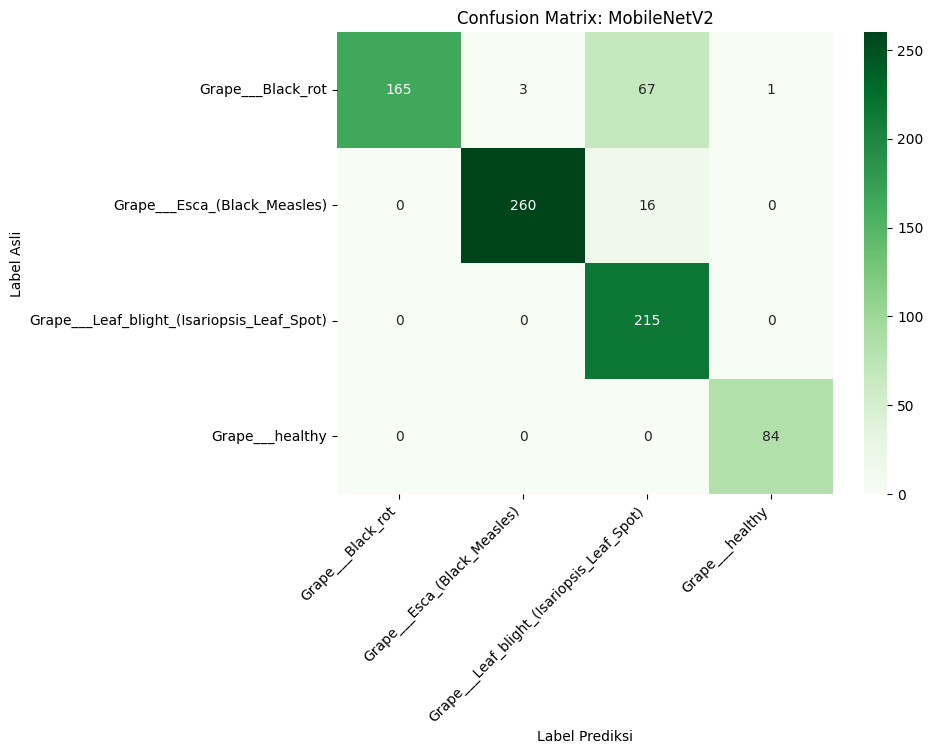


Laporan Klasifikasi MobileNetV2:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       1.00      0.70      0.82       236
              Grape___Esca_(Black_Measles)       0.99      0.94      0.96       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.72      1.00      0.84       215
                           Grape___healthy       0.99      1.00      0.99        84

                                  accuracy                           0.89       811
                                 macro avg       0.92      0.91      0.90       811
                              weighted avg       0.92      0.89      0.89       811

Custom CNN  : 97.62%
MobileNetV2 : 99.37%


In [ ]:
if battle_results:
    print("\n" + "="*40)
    print("📊 HASIL AKHIR")
    print("="*40)
    
    histories = {name: res['history'] for name, res in battle_results.items()}
    plot_battle_results(histories)
    
    for name, res in battle_results.items():
        print(f"\n>>> Analisis Detail: {name} <<<")
        show_confusion_matrix(res['y_true'], res['y_pred'], name)

    acc_custom = max(battle_results['Custom CNN']['history']['val_accuracy'])
    acc_mobile = max(battle_results['MobileNetV2']['history']['val_accuracy'])
    
    print(f"Custom CNN  : {acc_custom*100:.2f}%")
    print(f"MobileNetV2 : {acc_mobile*100:.2f}%")

In [ ]:
# if 'cached_models' not in globals():
#     print("⚙️ Membangun dan Memuat Model ke Memori (Hanya sekali)...")
#     cached_models = {}
#     builders = dict(models_list)
    
#     for name, weights in weights_storage.items():
#         # Build arsitektur
#         model = builders[name]()
#         model.set_weights(weights)
        
#         dummy_data = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
#         model.predict(preprocess_input(dummy_data), verbose=0)
        
#         cached_models[name] = model
#     print("✅ Model siap digunakan!")
# else:
#     print("⚡ Menggunakan model yang sudah aktif di memori...")

⚡ Menggunakan model yang sudah aktif di memori...


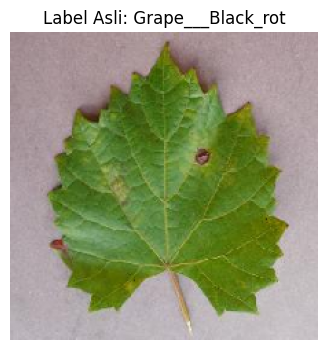

File: Grape___Black_rot\11d33215-d6b5-4a54-b41f-a6af58187681___FAM_B.Rot 0759.JPG


In [ ]:
import random

if cached_models:
    # Ambil 1 gambar acak
    idx = random.randint(0, len(test_generator.filenames) - 1)
    file_path = test_generator.filenames[idx]
    true_label = class_names[test_generator.classes[idx]]
    full_path = os.path.join(test_generator.directory, file_path)

    # Tampilkan
    pil_image = load_img(full_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.figure(figsize=(4, 4))
    plt.imshow(pil_image)
    plt.title(f"Label Asli: {true_label}")
    plt.axis('off')
    plt.show()

    # Prediksi
    print(f"File: {file_path}")
    input_tensor = img_to_array(pil_image)
    input_tensor = np.expand_dims(input_tensor, axis=0)
    input_tensor = preprocess_input(input_tensor)

    for name, model in cached_models.items():
        probs = model.predict(input_tensor, verbose=0)[0]
        pred_idx = np.argmax(probs)
        pred_label = class_names[pred_idx]
        confidence = probs[pred_idx]
        
        status = "✅" if pred_label == true_label else "❌"
        print(f"{status} {name:12} -> Prediksi: {pred_label} ({confidence*100:.2f}%)")
else:
    print("⚠️ Tidak ada model yang dilatih. Jalankan loop training dulu.")